# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src import plotter as plotter
from src import model as model

plotter.initialize(plt)

# Configure the model parameters

In [2]:
# Global settings
vmax = 4.2
vmin = 3.0

# Configure model parameters

# R-RC parameters
R0 = 0.082
R1 = 0.158
C1 = 38000
q_max_ah = 5 # Cell capacity in amp-hours

# eSOH parameters
Cn = 5 # Ah
Cp = 6 # Ah
theta_n_init = 0.0
theta_p_init = 1.0

# Simulation parameters
dt               = 1.0
sim_time_seconds = 30*3600 # Total simulation time
t_vec            = np.arange(0, sim_time_seconds, dt)

I_in = 0.5 * np.ones(t_vec.shape) # Amperes, positive is charge
I_cv = 0.5 / 20 

theta_n_vec = model.initialize_sim_vec(t_vec, theta_n_init)
theta_p_vec = model.initialize_sim_vec(t_vec, theta_p_init)
ocv_n_vec   = model.initialize_sim_vec(t_vec, model.Un(theta_n_init))
ocv_p_vec   = model.initialize_sim_vec(t_vec, model.Up(theta_p_init))
vt_vec      = model.initialize_sim_vec(t_vec, ocv_p_vec[0] - ocv_n_vec[0])
ocv_vec     = model.initialize_sim_vec(t_vec, ocv_p_vec[0] - ocv_n_vec[0])
I_r1_vec    = model.initialize_sim_vec(t_vec, 0)


In [5]:

mode = 'cc_charge'

for k in range(0, len(t_vec) - 1):

    # Constant current
    if mode == 'cc_charge':

        print('CC Charge')

        dQ = I_in[k] * dt / 3600 # Amp-hours    

        # Stoichiometry update
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        # Equilibrium potential updates
        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])
        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        # Current updates (branch current for RC element)
        I_r1_vec[k+1] =       np.exp(-dt/(R1*C1))  * I_r1_vec[k] + \
                         (1 - np.exp(-dt/(R1*C1))) * I_in[k]

        # Terminal voltage update
        vt_vec[k+1] = ocv_vec[k+1] + R1 * I_r1_vec[k] + R0 * I_in[k]

        # Check for constant voltage condition
        if vt_vec[k+1] >= vmax:
           mode = 'cv_charge'
           vt_vec[k+1] = vmax
        
    # Constant voltage
    elif mode == 'cv_charge':
        
        print ('CV Charge')

        # Input current update
        I_in[k+1] = ( vt_vec[k] - ocv_vec[k] - R1 * np.exp(-dt/(R1*C1)) * I_r1_vec[k] ) / \
                    ( ( 1 - np.exp(-dt/(R1*C1)) ) * R1 + R0 )

        # Branch current update
        I_r1_vec[k+1] =        np.exp(-dt/(R1*C1))  * I_r1_vec[k] + \
                          (1 - np.exp(-dt/(R1*C1))) * I_in[k+1]

        dQ = I_in[k] * dt / 3600

        # Stoichiometry update
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        # Equilibrium potential updates
        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])
        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        # Current updates (branch current for RC element)
        I_r1_vec[k+1] =       np.exp(-dt/(R1*C1))  * I_r1_vec[k] + \
                         (1 - np.exp(-dt/(R1*C1))) * I_in[k] 

        # Terminal voltage update
        vt_vec[k+1] = vmax

        # Check end-of-CV condition
        if np.abs( I_in[k+1] ) < np.abs( I_cv ):
            mode = 'cc_discharge'
            continue


    elif mode == 'cc_discharge':

        print(' CC Discharge ')

        dQ = -I_in[k] * dt / 3600 # Amp-hours    

        # Stoichiometry update
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        # Equilibrium potential updates
        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])
        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        # Current updates (branch current for RC element)
        I_r1_vec[k+1] =       np.exp(-dt/(R1*C1))  * I_r1_vec[k] + \
                         (1 - np.exp(-dt/(R1*C1))) * -I_in[k]

        assert ~np.isnan(I_r1_vec[k+1]), 'doh'

        # Terminal voltage update
        vt_vec[k+1] = ocv_vec[k+1] + R1 * I_r1_vec[k] + R0 * -I_in[k]

        # Check for constant voltage condition
        if vt_vec[k+1] <= vmin: 
           break


    # if k % 10 == 0:
        # print(f'k = {k}, t = {t_vec[k]}s, ' +
            #   f'Un = {ocv_n_vec[k]:.4f}, Up = {ocv_p_vec[k]:.4f}, ' + 
            #   f'Vt = {vt_vec[k]:.5f}V ' +
            #   f'x = {theta_n_vec[k]:.3f}, y = {theta_p_vec[k]:.3f}')


CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge
CC Charge


# Visualize and save the results

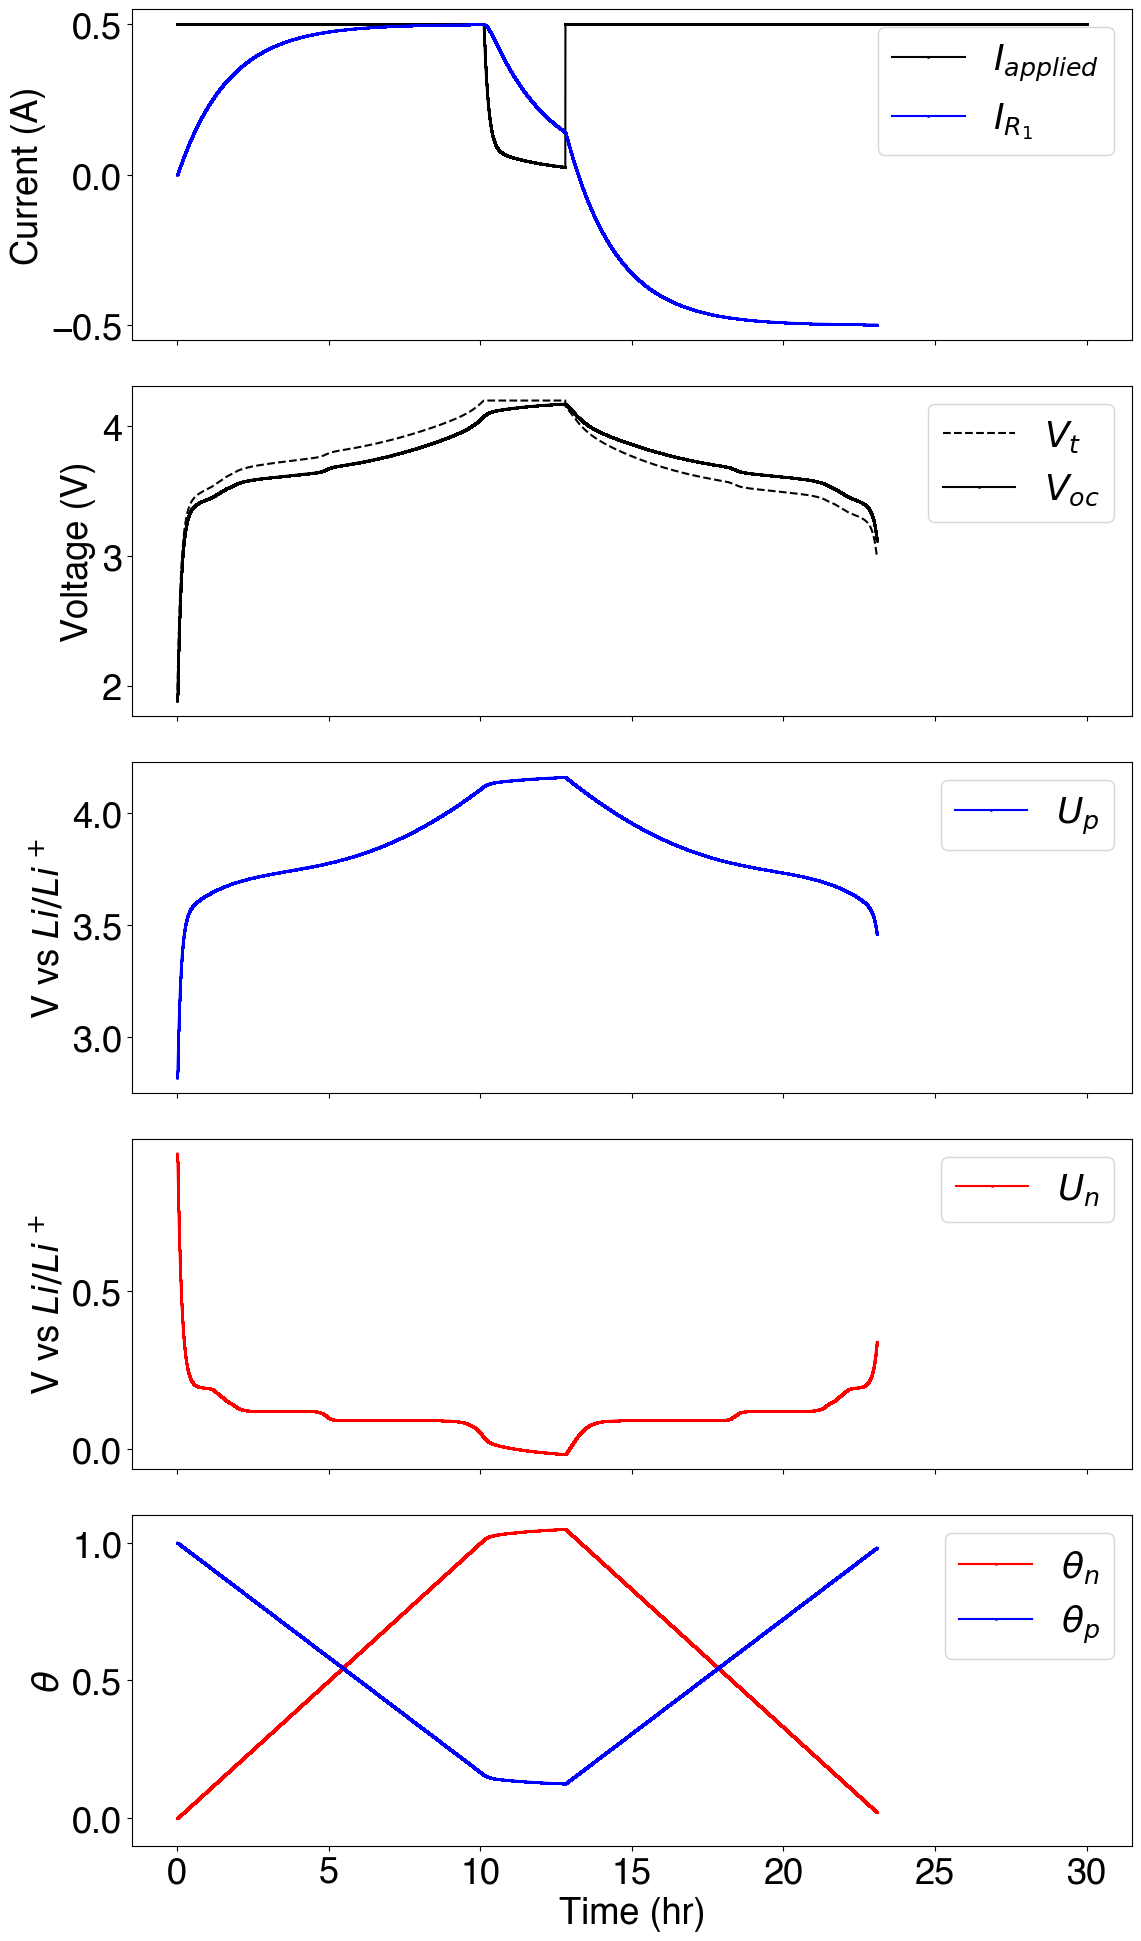

In [6]:

fig, axs = plt.subplots(5, figsize=(12, 20), sharex=True)

[ax.grid(False) for ax in axs]

# Currents
axs[0].plot(t_vec/3600, I_in,
            color='k',
            marker='o', markersize=1)
axs[0].plot(t_vec/3600, I_r1_vec,
            color='b',
            marker='o', markersize=1)
axs[0].set_ylabel('Current (A)')
axs[0].legend(['$I_{applied}$', '$I_{R_1}$'])

# Voltages and Potentials
axs[1].plot(t_vec/3600, vt_vec,
            linestyle='--',
            color='k')
axs[1].plot(t_vec/3600, ocv_vec,
            marker='o', markersize=1,
            color='k')
axs[1].legend(['$V_t$', '$V_{oc}$'])
axs[1].set_ylabel('Voltage (V)')

axs[2].plot(t_vec/3600, ocv_p_vec,
            marker='o', markersize=1,
            color='b')
axs[2].legend(['$U_p$'])
axs[2].set_ylabel('V vs $Li/Li^+$')

axs[3].plot(t_vec/3600, ocv_n_vec,
            marker='o', markersize=1,
            color='r')
axs[3].legend(['$U_n$'])
axs[3].set_ylabel('V vs $Li/Li^+$')

# SOC and Lithium Stoichiometries
# axs[2].plot(t_vec/3600, z_vec,
            # marker='o', markersize=1,
            # color='k')

axs[4].set_xlabel('Time (hr)')
axs[4].set_ylim((-0.1, 1.1))
axs[4].set_ylabel(r'$\theta$')

axs[4].plot(t_vec/3600, theta_n_vec,
              color='r',
              marker='o', markersize=1)

axs[4].plot(t_vec/3600, theta_p_vec,
              color='b',
              marker='o', markersize=1)

axs[4].legend([r'$\theta_n$', r'$\theta_p$'])

plt.tight_layout()
plt.savefig('outputs/figures/fig_formation_simulation.png', dpi=300)

